# 2. Load and train model

### 1. Import dependencies¶

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [4]:
torch.__version__

'1.4.0'

### 2. Create PyTorch data generators¶

In [6]:
from GTSRB_Test import GTSRB_Test 

# define dataloader parameters
batch_size = 32
num_workers_train = 2
num_workers_validation = 4
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train':
    datasets.ImageFolder('./source_data/train/GTSRB/Final_Training/Images', data_transforms['train']),
    'validation': 
    GTSRB_Test(
        images_dir  = './source_data/test/GTSRB/Final_Test/Images', 
        gt_csv_path = './source_data/test/GT-final_test.csv', transform=data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=batch_size,
                                shuffle=True, num_workers=num_workers_train),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=batch_size,
                                shuffle=False, num_workers=num_workers_validation)
}

In [ ]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

### 3. Create the network¶

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

### 4. Train the model¶

In [8]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            train_loss = 0.0
            i = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)                                

                epoch_loss = running_loss / len(image_datasets[phase])
                epoch_acc = running_corrects.float() / len(image_datasets[phase])
                train_loss += loss.item()
                if i % 20 == 19:
                    print('phase: {}, batch: {}, loss: {:.4f}, train_loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                                        i+1,
                                                                        epoch_loss.item(),
                                                                        train_loss / 20,
                                                                        epoch_acc.item()))
                    train_loss = 0.0
                i += 1




#            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
#                                                        epoch_loss.item(),
#                                                        epoch_acc.item()))
    return model

In [9]:
model_trained = train_model(model, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------
train loss: 0.4736, acc: 0.7594
validation loss: 0.3061, acc: 0.8500
Epoch 2/3
----------
train loss: 0.2406, acc: 0.9020
validation loss: 0.2415, acc: 0.9050
Epoch 3/3
----------
train loss: 0.2319, acc: 0.9006
validation loss: 0.2235, acc: 0.9000


### 5. Save and load the model¶

In [12]:
torch.save(model_trained.state_dict(), 'weights.h5')

In [13]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('weights.h5'))

<All keys matched successfully>

### 6. Make predictions on sample test images¶

In [10]:
from PIL import Image
validation_img_paths = ["./source_data/test/GTSRB/Final_Test/Images/00000.ppm",
                        "./source_data/test/GTSRB/Final_Test/Images/00001.ppm",
                        "./source_data/test/GTSRB/Final_Test/Images/00002.ppm"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [17]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [18]:
pred_logits_tensor = model(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

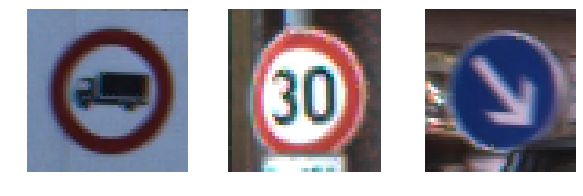

In [18]:
fig, axs = plt.subplots(1, len(img_list), figsize=(10, 3))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
#    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
#                                                          100*pred_probs[i,1]))
    ax.imshow(img)